#### Pulling data from fredapi

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from fredapi import Fred
sns.set

#Initializing fredapi
fred = Fred(api_key = 'f7a64d5acdc11f5d761fe5d9c28ca5fa')
series_ids =['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', \
              'DGS7', 'DGS10', 'DGS20', 'DGS30']
#Creating Function
def get_series_data(series_id, start, end):
    data = fred.get_series(series_id, observation_start = start, observation_end = end)
    return data
#creating dictionary of the series
start = "2001-01-01"
end = "2024-12-31"
yields_dict = {series_id: get_series_data(series_id, start, end) for series_id in series_ids}
#creating data frame
yields_df = pd.DataFrame(yields_dict)
#renaming columns
yields_df.columns = ['1 month', '3 months', '6 months', '1 year', '2 years', '3 years', '5 years', '7 years', '10 years', '20 years', '30 years']
yields_df.head()

,1 month,3 months,6 months,1 year,2 years,3 years,5 years,7 years,10 years,20 years,30 years
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,NaN,5.87,5.58,5.11,4.87,4.82,4.76,4.97,4.92,5.46,5.35
2001-01-03,NaN,5.69,5.44,5.04,4.92,4.92,4.94,5.18,5.14,5.62,5.49
2001-01-04,NaN,5.37,5.20,4.82,4.77,4.78,4.82,5.07,5.03,5.56,5.44
2001-01-05,NaN,5.12,4.98,4.60,4.56,4.57,4.66,4.93,4.93,5.50,5.41


### Fitting NS model

NelsonSiegelCurve(beta0=np.float64(3.9583206600317427), beta1=np.float64(1.1845879250204785), beta2=np.float64(3.2367486382322532), tau=np.float64(0.40486325975998416))


Text(0.5, 1.0, 'NS Model')

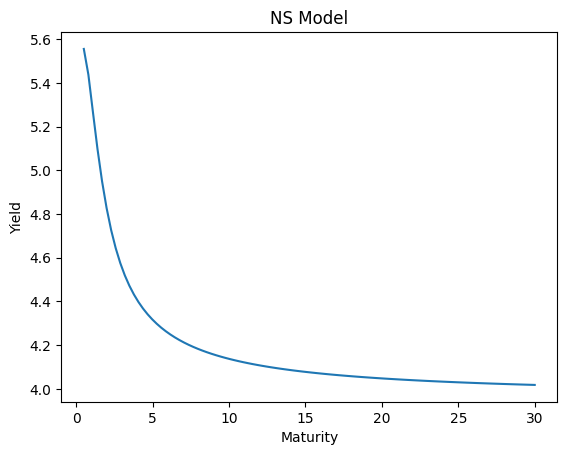

In [83]:
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
#creating maturities in terms of years
maturities = [0.0833, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
t = np.array(maturities)
y = np.array(yields_df.loc["2023-07-10"])
curve, status = calibrate_ns_ols(t, y, tau0 = 1.0)
assert status.success
print(curve)
#creating simulation of 100 point
y_ns = curve
t_ns = np.linspace(0.5, 30, 100)
plt.plot(t_ns, y_ns(t_ns))
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("NS Model")

### Cubic spline interpolation

$$A = \begin{bmatrix} 
   a & b \\
   c & d
\end{bmatrix}$$

In [84]:
print(y)

[5.34 5.48 5.54 5.38 4.85 4.54 4.25 4.14 4.01 4.24 4.05]


#### Selecting sample points

In [85]:
t_spline = np.array([2, 5, 10, 30])
M = ["2 years", "5 years", "10 years", "30 years"]
y_spline = np.array([yields_df.loc["2023-07-10", i] for i in M ])
print(np.vstack((t_spline, y_spline)))

[[ 2.    5.   10.   30.  ]
 [ 4.85  4.25  4.01  4.05]]


#### Genearing the 12 equations and their Linear system

After getting the equations, by putting into matrices, we obtain a linear system of the form:
$$A*C = y$$
<br>
A: The coefficient matrix
<br>
C: the variable matrix
<br>
y: the output
<br>
$$C = A^{-1}*y$$

#### Putting the matrices in a numpy array

In [94]:
y = np.array([4.85, 4.25, 4.25, 4.01, 4.01, 4.05, 0, 0, 0, 0, 0, 0])
A = np.array([[8,4,2,1,0,0,0,0,0,0,0,0],[125,25,5,1,0,0,0,0,0,0,0,0],[0,0,0,0,125,25,5,1,0,0,0,0],[0,0,0,0,1000,100,10,1,0,0,0,0], \
                  [0,0,0,0,0,0,0,0,1000,100,10,1],[0,0,0,0,0,0,0,0,27000,900,30,1],[75,10,1,0,-75,-10,-1,0,0,0,0,0],[0,0,0,0,300,20,1,0,-300,-20,-1,0], \
                  [30,2,0,0,-30,-2,0,0,0,0,0,0],[0,0,0,0,60,2,0,0,-60,-2,0,0],[12,2,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,180,2,0,0]])
C = np.round(np.dot(np.linalg.inv(A), y.reshape(-1,1)), decimals = 6).reshape(3,-1)

the output of the matrix above is of the form:
$$A = \begin{bmatrix}
    a_1 & b_1 & c_1 & d_1 \\
    a_2 & b_2 & c_2 & d_2 \\
    a_3 & b_3 & c_3 & d_3 \\
    a_4 & b_4 & c_4 & d_4
\end{bmatrix}$$

#### Writting the function that calculates:
$$x^0 + x^1 + x^2 + x^3$$

In [95]:
def spline_interpol(coeffs, variables):
    expansion = np.hstack([coeffs[i]*(variables**i)for i in range(0, len(coeffs))])
    return np.sum(expansion, axis = 1)
"""
note that the coefficient matrix will be passed row by row after each row has been reversed.
#the row are reversed so that each coefficient is multiplied to the correct power of x, i starts from 0, 
not reversing the rows will geneate wrong output
"""

'\nnote that the coefficient matrix will be passed row by row after each row has been reversed.\n#the row are reversed so that each coefficient is multiplied to the correct power of x, i starts from 0, \nnot reversing the rows will geneate wrong output\n'

if the first row of the coefficient matrix is passed into the function, the expansion matrix will look like:
$$d_1\begin{bmatrix} 
   x_1^0\\
   x_2^0\\
   x_3^0\\
   .\\
   .\\
   .\\
   x_n^0
\end{bmatrix} + c_1\begin{bmatrix} 
   x_1^!\\
   x_2^1\\
   x_3^1\\
   .\\
   .\\
   .\\
   x_n^1
\end{bmatrix} + b_1\begin{bmatrix} 
   x_1^2\\
   x_2^2\\
   x_3^2\\
   .\\
   .\\
   .\\
   x_n^2
\end{bmatrix} + a_1\begin{bmatrix} 
   x_1^3\\
   x_2^3\\
   x_3^3\\
   .\\
   .\\
   .\\
   x_n^3
\end{bmatrix}$$

#### Simulating 100 values of x and applying the above function to get the respective values of y

In [96]:
x_values = np.linspace(2,30,100)
# for values of x that are less than 5
y_1 = spline_interpol(C[0][::-1], x_values[x_values < 5].reshape(-1, 1))
# for values of x that are greater than or equal to 5 to x < 10
y_2 = spline_interpol(C[1][::-1], x_values[(x_values >= 5) & (x_values < 10)].reshape(-1, 1))
# from 10 to 30
y_3 = spline_interpol(C[2][::-1], x_values[x_values >= 10].reshape(-1, 1))
y_values = np.concatenate([y_1, y_2, y_3])
print(y_values)

[4.849997   4.78545454 4.72134084 4.65808499 4.59611608 4.5358632
 4.47775542 4.42222184 4.36969155 4.32059362 4.27535714 4.23449841
 4.19798732 4.16567245 4.1372978  4.11260735 4.09134508 4.073255
 4.05808107 4.0455673  4.03545766 4.02749615 4.02142675 4.01699345
 4.01394024 4.0120111  4.01095002 4.01050099 4.010408   4.00952638
 4.00949849 4.00949263 4.00950838 4.00954533 4.00960309 4.00968123
 4.00977935 4.00989706 4.01003393 4.01018956 4.01036355 4.01055548
 4.01076496 4.01099156 4.0112349  4.01149455 4.01177011 4.01206118
 4.01236734 4.01268819 4.01302333 4.01337234 4.01373481 4.01411035
 4.01449854 4.01489898 4.01531126 4.01573496 4.01616969 4.01661504
 4.0170706  4.01753596 4.01801072 4.01849446 4.01898679 4.01948729
 4.01999556 4.02051118 4.02103376 4.02156288 4.02209814 4.02263913
 4.02318544 4.02373667 4.02429241 4.02485225 4.02541578 4.0259826
 4.0265523  4.02712447 4.02769871 4.02827461 4.02885175 4.02942974
 4.03000817 4.03058662 4.0311647  4.03174199 4.03231809 4.03289259

#### Plotting the result

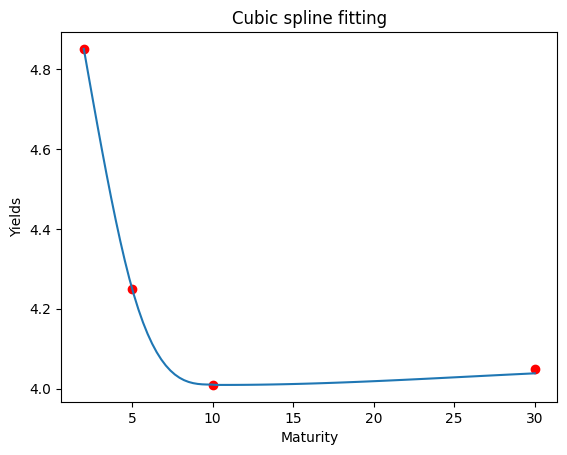

In [97]:
plt.plot(x_values, y_values)
plt.scatter(t_spline, y_spline, c = "red")
plt.xlabel("Maturity")
plt.ylabel("Yields")
plt.title("Cubic spline fitting")
plt.show()

In [93]:
print(C)

[[ 3.960000e-04 -2.376000e-03  2.452200e-02  1.517294e+00]
 [-3.310000e-04  8.535000e-03 -3.003800e-02  1.608226e+00]
 [ 2.300000e-05 -2.110000e-03  7.641400e-02  1.253387e+00]]
